In [ ]:
pip install catboost

In [ ]:
pip install xgboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
df_train = pd.read_csv("train.csv")
df_train.head()

Id        AB          AF          AH         AM        AR  \
0  000ff2bfdfe9  0.209377  3109.03329   85.200147  22.394407  8.138688   
1  007255e47698  0.145282   978.76416   85.200147  36.968889  8.138688   
2  013f2bd269f5  0.470030  2635.10654   85.200147  32.360553  8.138688   
3  043ac50845d5  0.252107  3819.65177  120.201618  77.112203  8.138688   
4  044fb8a146ec  0.380297  3733.04844   85.200147  14.103738  8.138688   

         AX        AY         AZ          BC  ...        FL        FR  \
0  0.699861  0.025578   9.812214    5.555634  ...  7.298162   1.73855   
1  3.632190  0.025578  13.517790    1.229900  ...  0.173229   0.49706   
2  6.732840  0.025578  12.824570    1.229900  ...  7.709560   0.97556   
3  3.685344  0.025578  11.053708    1.229900  ...  6.122162   0.49706   
4  3.942255  0.054810   3.396778  102.151980  ...  8.153058  48.50134   

         FS         GB          GE            GF         GH         GI  \
0  0.094822  11.339138   72.611063   2003.810319  22.136229  69.834944   
1  0.568932   9.292698   72.611063  27981.562750  29.135430  32.131996   
2  1.198821  37.077772   88.609437  13676.957810  28.022851  35.192676   
3  0.284466  18.529584   82.416803   2094.262452  39.948656  90.493248   
4  0.121914  16.408728  146.109943   8524.370502  45.381316  36.262628   

          GL  Class  
0   0.120343      1  
1  21.978000      0  
2   0.196941      0  
3   0.155829      0  
4   0.096614      1  

[5 rows x 58 columns]

# Data Exploration

## Class distridution

There is a noticeable imbalance of objects in classes

<Axes: >

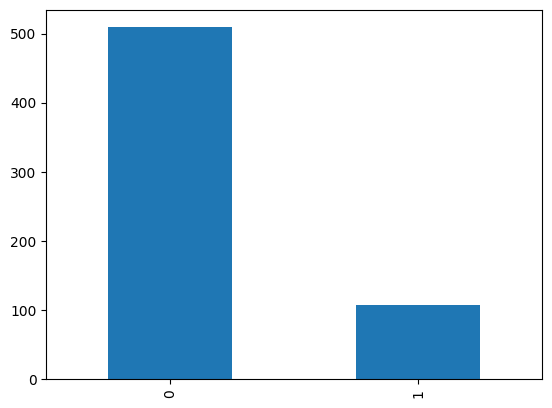

In [ ]:
df_train['Class'].value_counts().plot.bar()

## EJ distribution

A single column that has categorical data - EJ column. There is also an imbalance, but less pronounced.

<Axes: >

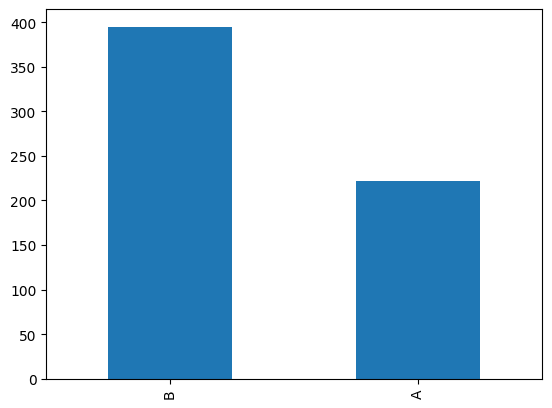

In [ ]:
df_train['EJ'].value_counts().plot.bar()

## Numeric data

There are too many numeric columns and they all have different properties. Let's make diagrams for the first 10

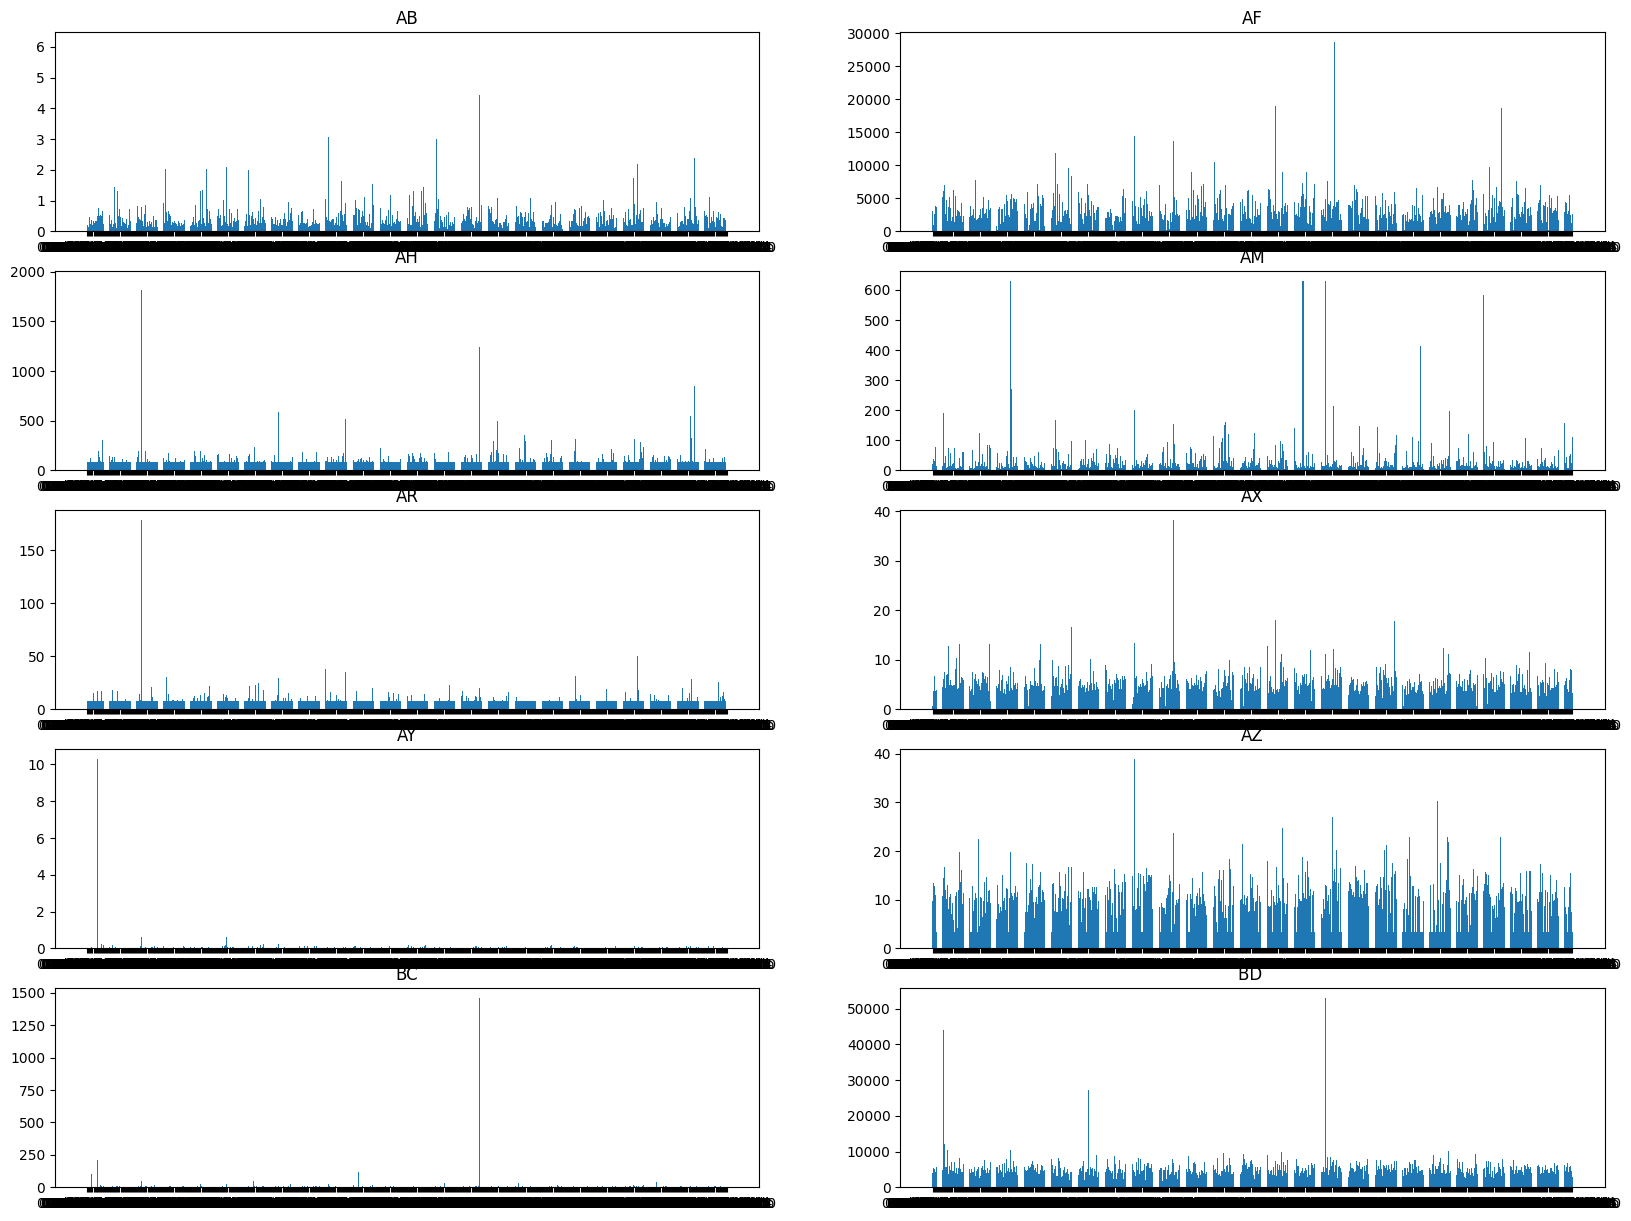

In [ ]:
columns_name = [i for i in df_train.columns if i not in ["Id", "EJ", "Class"]]
figure, axis = plt.subplots(5, 2, figsize=(20, 15))

for i, column_name in enumerate(columns_name[:10]):
    row = i//2
    col = i % 2
    axis[row, col].bar(x=df_train['Id'], height=df_train[column_name])
    axis[row, col].set_title(column_name)
plt.show()

## Overall statistics

In [ ]:
df_train.describe()

AB            AF           AH          AM          AR  \
count  617.000000    617.000000   617.000000  617.000000  617.000000   
mean     0.477149   3502.013221   118.624513   38.968552   10.128242   
std      0.468388   2300.322717   127.838950   69.728226   10.518877   
min      0.081187    192.593280    85.200147    3.177522    8.138688   
25%      0.252107   2197.345480    85.200147   12.270314    8.138688   
50%      0.354659   3120.318960    85.200147   20.533110    8.138688   
75%      0.559763   4361.637390   113.739540   39.139886    8.138688   
max      6.161666  28688.187660  1910.123198  630.518230  178.943634   

               AX          AY          AZ           BC           BD   ...  \
count  617.000000  617.000000  617.000000   617.000000    617.000000  ...   
mean     5.545576    0.060320   10.566447     8.053012   5350.388655  ...   
std      2.551696    0.416817    4.350645    65.166943   3021.326641  ...   
min      0.699861    0.025578    3.396778     1.229900   1693.624320  ...   
25%      4.128294    0.025578    8.129580     1.229900   4155.702870  ...   
50%      5.031912    0.025578   10.461320     1.229900   4997.960730  ...   
75%      6.431634    0.036845   12.969516     5.081244   6035.885700  ...   
max     38.270880   10.315851   38.971568  1463.693448  53060.599240  ...   

               FL           FR          FS          GB           GE  \
count  616.000000   617.000000  615.000000  617.000000   617.000000   
mean     5.433199     3.533905    0.421501   20.724856   131.714987   
std     11.496257    50.181948    1.305365    9.991907   144.181524   
min      0.173229     0.497060    0.067730    4.102182    72.611063   
25%      0.173229     0.497060    0.067730   14.036718    72.611063   
50%      3.028141     1.131000    0.250601   18.771436    72.611063   
75%      6.238814     1.512060    0.535067   25.608406   127.591671   
max    137.932739  1244.227020   31.365763  135.781294  1497.351958   

                  GF          GH          GI          GL       Class  
count     617.000000  617.000000  617.000000  616.000000  617.000000  
mean    14679.595398   31.489716   50.584437    8.530961    0.175041  
std     19352.959387    9.864239   36.266251   10.327010    0.380310  
min        13.038894    9.432735    0.897628    0.001129    0.000000  
25%      2798.992584   25.034888   23.011684    0.124392    0.000000  
50%      7838.273610   30.608946   41.007968    0.337827    0.000000  
75%     19035.709240   36.863947   67.931664   21.978000    0.000000  
max    143790.071200   81.210825  191.194764   21.978000    1.000000  

[8 rows x 56 columns]

Columns with empty values are present. Let's take a closer look at them

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

All columns, except for BQ and EL, have less than 1% of nan cells, so we can drop them. But BQ and EL have almost 10% of nan values. More exploration is needed.

In [ ]:
def is_above_zero(pair):
    key, value = pair
    return value > 0
res = {}
for c in df_train.columns:
  res[c] = df_train[c].isna().sum()/len(df_train)*100

columns_above_zero = dict(filter(is_above_zero, res.items()))
columns_above_zero

{'BQ': 9.724473257698541,
 'CB': 0.3241491085899514,
 'CC': 0.48622366288492713,
 'DU': 0.1620745542949757,
 'EL': 9.724473257698541,
 'FC': 0.1620745542949757,
 'FL': 0.1620745542949757,
 'FS': 0.3241491085899514,
 'GL': 0.1620745542949757}

(<Axes: >,
 count    557.000000
 mean      98.328737
 std       96.479371
 min        1.331155
 25%       27.834425
 50%       61.642115
 75%      134.009015
 max      344.644105
 Name: BQ, dtype: float64)

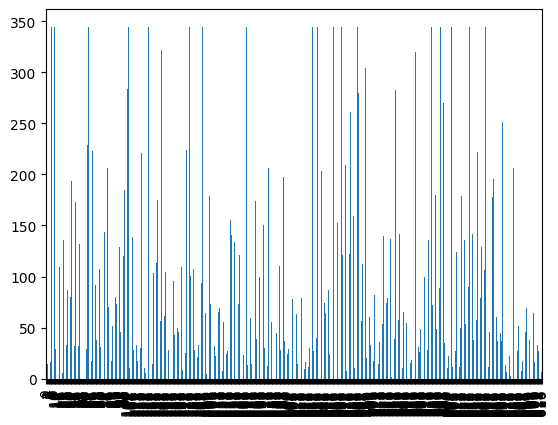

In [ ]:
df_train['BQ'].plot.bar(), df_train['BQ'].describe()

(<Axes: >,
 count    557.000000
 mean      69.582596
 std       38.555707
 min        5.394675
 25%       30.927468
 50%       71.949306
 75%      109.125159
 max      109.125159
 Name: EL, dtype: float64)

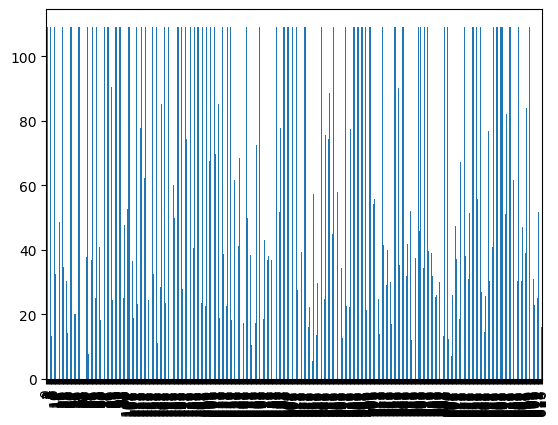

In [ ]:
df_train['EL'].plot.bar(), df_train['EL'].describe()

Fill empty cells with mean

## Correlation

Most of the columns have little correlation with each other. However, due to the large number of columns for class search, there is a possibility of use of finding the most important features.

<ipython-input-39-033d563b3b2e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_train.corr()


<Axes: >

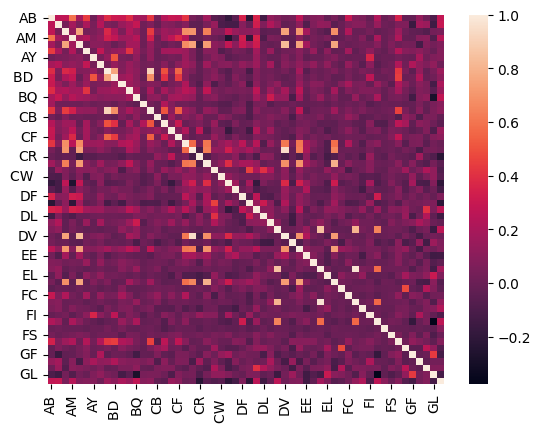

In [ ]:
corr = df_train.corr()

sns.heatmap(corr)

# Data preporation

In [ ]:
df_train[['BQ', 'EL']] = df_train[['BQ', 'EL']].fillna(df_train[['BQ', 'EL']].mean())

In [ ]:
df_train.dropna(subset=['CB', 'CC', 'DU','FC','FS','GL'], inplace=True)

In [ ]:
encoder = LabelEncoder()
df_train["EJ"] = encoder.fit_transform(df_train["EJ"])

In [ ]:
columns_name = [i for i in df_train.columns if i not in ["Id",  "Class"]]
X = df_train[columns_name]
y = df_train['Class']


# Baseline

At this stage it is proposed to analyze different log loss models in accordance with the goal of this competition. The following models were considered:

1. **CatBoostClassifier**
2. **XGBClassifier**
3. **LogisticRegression with elastic net penalty**
4. **SVM**
5. **AdaBoostClassifier**

The best result was showed by **CatBoostClassifier**, which will be used to find better parameters to improve score.

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
def calc_mean(models):
  res = 0
  for m in models:
    res+=m['validation']['Logloss']
  return res/len(models)

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    model = CatBoostClassifier(
    custom_loss=[metrics.Logloss()],
    random_seed=42,
    logging_level='Silent'
    )

    model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    plot=True
  )
    models.append(model.get_best_score())
models

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[{'learn': {'Logloss': 0.0028388275270176963},
  'validation': {'Logloss': 0.16279908320549782}},
 {'learn': {'Logloss': 0.002390531696505837},
  'validation': {'Logloss': 0.19945114033394984}},
 {'learn': {'Logloss': 0.002757252500587314},
  'validation': {'Logloss': 0.15760877766387732}},
 {'learn': {'Logloss': 0.0027948724870969143},
  'validation': {'Logloss': 0.21756173071646806}},
 {'learn': {'Logloss': 0.002773843255673288},
  'validation': {'Logloss': 0.16599758021812458}}]

In [ ]:
calc_mean(models)

0.18068366242758355

In [ ]:
xgb_models = []
xgb_oof = []
f_imp = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
    watchlist = [(X_train, y_train), (X_valid, y_valid)]

    model = XGBClassifier(n_jobs=-1, early_stopping_rounds=300,)
    model.fit(X_train, y_train, eval_set=watchlist, verbose=0)

    val_preds = model.predict_proba(X_valid)[:, 1]

    val_score = log_loss(y_valid, val_preds)

    idx_pred_target = np.vstack([val_idx,  val_preds, y_valid]).T
    f_imp.append({i: j for i, j in zip(X.columns, model.feature_importances_)})
    print(f'Log-loss: {val_score:.5f}')

    xgb_oof.append(idx_pred_target)
    xgb_models.append(model)

print(np.mean([log_loss(item[:, 2], item[:, 1]) for item in xgb_oof]))

Log-loss: 0.16398
Log-loss: 0.19987
Log-loss: 0.13326
Log-loss: 0.22499
Log-loss: 0.23033
0.19048536680288003


In [ ]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
score =[]
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]


    model = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5)
    model.fit(X_train,y_train)

    val_preds = model.predict_proba(X_valid)[:, 1]
    val_score = log_loss(y_valid, val_preds)

    print('LogLoss:',val_score)
    score.append(val_score)

print("Mean score: ", sum(score)/len(score))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogLoss: 0.6238813685392915
LogLoss:

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 0.5453475727315923
LogLoss: 0.43528546176079386
LogLoss: 0.5002651348459616
LogLoss: 0.42540673645882054
Mean score:  0.506037254867292


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

score =[]
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]


    model = SVC(probability=True)
    model.fit(X_train,y_train)

    val_preds = model.predict_proba(X_valid)[:, 1]
    val_score = log_loss(y_valid, val_preds)

    print('LogLoss:',val_score)
    score.append(val_score)

print("Mean score: ", sum(score)/len(score))

LogLoss: 0.4213713949882491
LogLoss: 0.4162353726475163
LogLoss: 0.4241238669726652
LogLoss: 0.5143296300724393
LogLoss: 0.40709590042714744
Mean score:  0.43663123302160345


In [ ]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

score =[]
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]


    model = AdaBoostClassifier(random_state=42)
    model.fit(X_train,y_train)

    val_preds = model.predict_proba(X_valid)[:, 1]
    val_score = log_loss(y_valid, val_preds)

    print('LogLoss:',val_score)
    score.append(val_score)

print("Mean score: ", sum(score)/len(score))

LogLoss: 0.5884403631683677
LogLoss: 0.6177108749562558
LogLoss: 0.6311532986140134
LogLoss: 0.6123478927651205
LogLoss: 0.6094830126788154
Mean score:  0.6118270884365146


# GridSearchCV

In [ ]:
parameters = {'depth'         : [4,6,8],
              'learning_rate' : [0.005, 0.01,0.03],
              'logging_level':['Silent'],
               'random_seed': [42],
                 }
model = CatBoostClassifier()
grid_search_result = model.grid_search(parameters,
                                       X=X,
                                       y=y,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.2511523	best: 0.2511523 (0)	total: 13.4s	remaining: 1m 47s
1:	loss: 0.2319536	best: 0.2319536 (1)	total: 19.7s	remaining: 1m 8s
2:	loss: 0.2345500	best: 0.2319536 (1)	total: 25.6s	remaining: 51.3s
3:	loss: 0.2515993	best: 0.2319536 (1)	total: 39.9s	remaining: 49.9s
4:	loss: 0.2438477	best: 0.2319536 (1)	total: 54.6s	remaining: 43.7s
5:	loss: 0.2427392	best: 0.2319536 (1)	total: 1m 11s	remaining: 36s
6:	loss: 0.2654543	best: 0.2319536 (1)	total: 1m 59s	remaining: 34s
7:	loss: 0.2588624	best: 0.2319536 (1)	total: 2m 47s	remaining: 21s
8:	loss: 0.2646506	best: 0.2319536 (1)	total: 3m 39s	remaining: 0us
Estimating final quality...


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    model = CatBoostClassifier(
    custom_loss=[metrics.Logloss()],
    random_seed=42,
    logging_level='Silent',
    depth=4,
    iterations=1000,
    learning_rate=0.01
    )

    model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    plot=True
  )
    models.append(model.get_best_score())
models

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[{'learn': {'Logloss': 0.03303609988395056},
  'validation': {'Logloss': 0.16565739683140923}},
 {'learn': {'Logloss': 0.025555643268264754},
  'validation': {'Logloss': 0.20379694174121768}},
 {'learn': {'Logloss': 0.029435961307691678},
  'validation': {'Logloss': 0.15148331658339562}},
 {'learn': {'Logloss': 0.03104480888732538},
  'validation': {'Logloss': 0.21626750005608575}},
 {'learn': {'Logloss': 0.03152000938485167},
  'validation': {'Logloss': 0.17663808483704946}}]

In [ ]:
calc_mean(models)

0.18276864800983156